<h1 style='text-align: center;'>MODELING (HYPERPARAMETER TUNING)</h1>

### Import the Libraries

In [9]:
import warnings
warnings.filterwarnings("ignore")

from joblib import load

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

import torch
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

import plotly.offline as pyo
pyo.init_notebook_mode()

import optuna

from sklearn.metrics import f1_score

from pprint import pprint
import os

### Load the Data

In [10]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/serialized-uti-data/preprocessed_unscaled_data.joblib
/kaggle/input/serialized-uti-data/preprocessed_data.joblib


In [11]:
X_train_scaled, _, y_train, _ = load(r"/kaggle/input/serialized-uti-data/preprocessed_data.joblib")

In [12]:
X_train_scaled

Age     Color  Transparency  Glucose  Protein        pH  \
0     0.010870  0.571429          0.25      0.0     0.25  0.000000   
1     0.043478  0.428571          0.25      0.0     0.50  0.441672   
2     0.032609  0.000000          0.00      0.0     0.25  0.333333   
3     0.010870  0.714286          0.00      0.0     0.00  0.333333   
4     0.206522  0.571429          0.00      0.0     0.25  0.333333   
...        ...       ...           ...      ...      ...       ...   
1890  0.021739  0.571429          0.50      0.0     0.25  0.333333   
1891  0.250000  0.714286          0.25      0.0     0.25  0.348631   
1892  0.108696  0.714286          0.25      0.0     0.00  0.666667   
1893  0.250000  0.571429          0.50      0.0     0.25  0.500000   
1894  0.021739  0.714286          0.00      0.0     0.00  0.500000   

      Specific Gravity       WBC       RBC  Epithelial Cells  Mucous Threads  \
0             1.000000  0.333333  0.000000          0.166667        0.666667   
1             0.334997  0.416667  0.583333          0.166667        0.000000   
2             0.400000  0.666667  1.000000          0.166667        0.000000   
3             0.800000  0.000000  0.083333          0.166667        0.333333   
4             0.600000  0.250000  0.416667          0.166667        0.666667   
...                ...       ...       ...               ...             ...   
1890          0.800000  0.750000  0.000000          0.166667        0.000000   
1891          0.218357  0.916667  0.083333          0.166667        0.000000   
1892          0.400000  0.500000  0.000000          0.500000        0.333333   
1893          0.400079  0.916667  0.083333          0.666667        0.000000   
1894          0.200000  0.000000  0.000000          0.166667        0.333333   

      Amorphous Urates  Bacteria  FEMALE  
0             0.000000       0.2    True  
1             0.333333       0.6    True  
2             0.000000       0.0    True  
3             0.000000       0.2    True  
4             0.000000       0.2   False  
...                ...       ...     ...  
1890          0.000000       1.0    True  
1891          0.000000       0.8    True  
1892          0.000000       0.2    True  
1893          0.000000       0.6    True  
1894          0.000000       0.0    True  

[1895 rows x 14 columns]

In [13]:
y_train

372     0
1524    1
1157    0
165     0
196     0
       ..
1489    1
1866    1
153     0
1911    1
100     0
Name: Diagnosis, Length: 1895, dtype: int64

### Splitting the Train Set for Validation Set

In [14]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train_scaled, 
                                                                    y_train, 
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                   stratify = y_train)

### Hyperparameter Tuning

In [15]:
def show_study_summary(study):
    """
    Display a summary of the optimization study.

    Parameters
    ----------
    study : optuna.study.Study
        The optimization study to summarize.

    Returns
    -------
    None
        This function does not return any values. It displays information and plots.
    """
    print("\033[1mBest Hyperparameters")
    pprint(study.best_params)
    print()

    print("\033[1mAccuracy for the Best Hyperparameters")
    print(study.best_value)

    optimization_history_plot = optuna.visualization.plot_optimization_history(study)
    param_importances_plot = optuna.visualization.plot_param_importances(study)
    parallel_coordinate_plot = optuna.visualization.plot_parallel_coordinate(study)

    optimization_history_plot.update_layout({"height": 600})
    param_importances_plot.update_layout({"height": 600})
    parallel_coordinate_plot.update_layout({"height": 600})

    optimization_history_plot.show()
    param_importances_plot.show()
    parallel_coordinate_plot.show()

### Logistic Regression

In [16]:
def logreg_objective(trial):
    """
    Objective function for optimizing logistic regression hyperparameters.

    Parameters
    ----------
    trial : optuna.Trial
        A single optimization trial.

    Returns
    -------
    float
        F1 score obtained using the specified hyperparameters.
    """
    params = {
        "tol": trial.suggest_float("tol", 1e-6, 1e-2, log=True),
        "C": trial.suggest_float("C", 0.1, 1)
    }

    logreg = LogisticRegression(**params, max_iter=2000)

    logreg.fit(X_train_val, y_train_val)

    threshold = trial.suggest_float('threshold', 0.1, 1)

    yhat = [1 if proba[1] > threshold else 0 for proba in logreg.predict_proba(X_test_val)]

    f1_score_ = f1_score(y_test_val, yhat)

    return f1_score_

log_reg_study = optuna.create_study(direction="maximize", study_name="logreg_tuning")

log_reg_study.optimize(logreg_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-11-20 07:08:58,160] A new study created in memory with name: logreg_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-11-20 07:08:58,269] Trial 1 finished with value: 0.9571788413098236 and parameters: {'tol': 6.823459076932654e-06, 'C': 0.21391887412796923, 'threshold': 0.4595033255898734}. Best is trial 1 with value: 0.9571788413098236.
[I 2023-11-20 07:08:58,318] Trial 2 finished with value: 0.9547738693467337 and parameters: {'tol': 0.00026552536827421756, 'C': 0.7310749349493189, 'threshold': 0.3862619761239716}. Best is trial 1 with value: 0.9571788413098236.
[I 2023-11-20 07:08:58,344] Trial 0 finished with value: 0.9644670050761421 and parameters: {'tol': 7.572470100317364e-06, 'C': 0.8238694650046736, 'threshold': 0.4663328855166039}. Best is trial 0 with value: 0.9644670050761421.
[I 2023-11-20 07:08:58,352] Trial 3 finished with value: 0.9523809523809523 and parameters: {'tol': 0.002892947404632163, 'C': 0.8992399592870023, 'threshold': 0.36032612902403294}. Best is trial 0 with value: 0.9644670050761421.
[I 2023-11-20 07:08:58,459] Trial 4 finished with value: 0.9642857142857142 an

Best Hyperparameters
{'C': 0.6500567615527497,
 'threshold': 0.4687071263659064,
 'tol': 0.00016887831612070643}

Accuracy for the Best Hyperparameters
0.9669211195928753


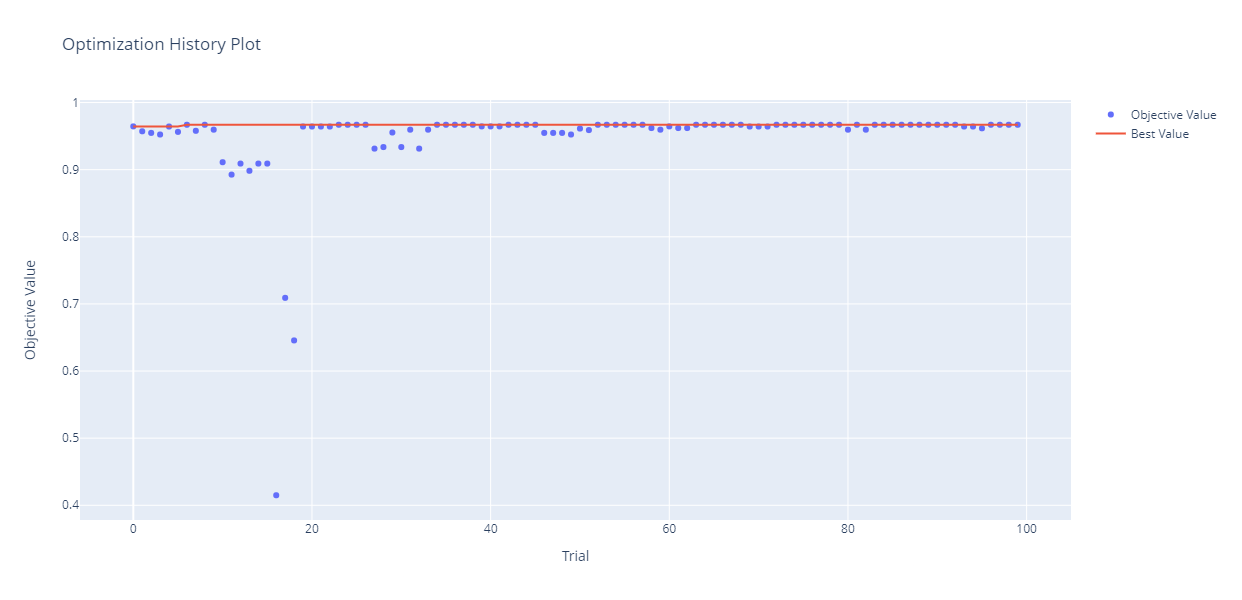

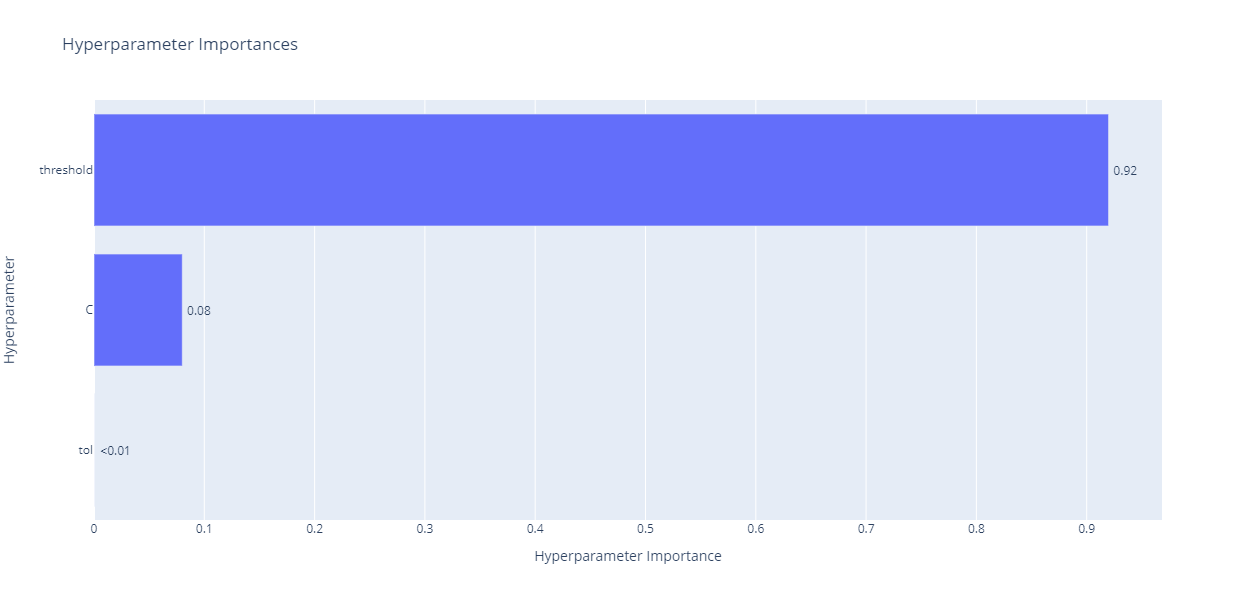

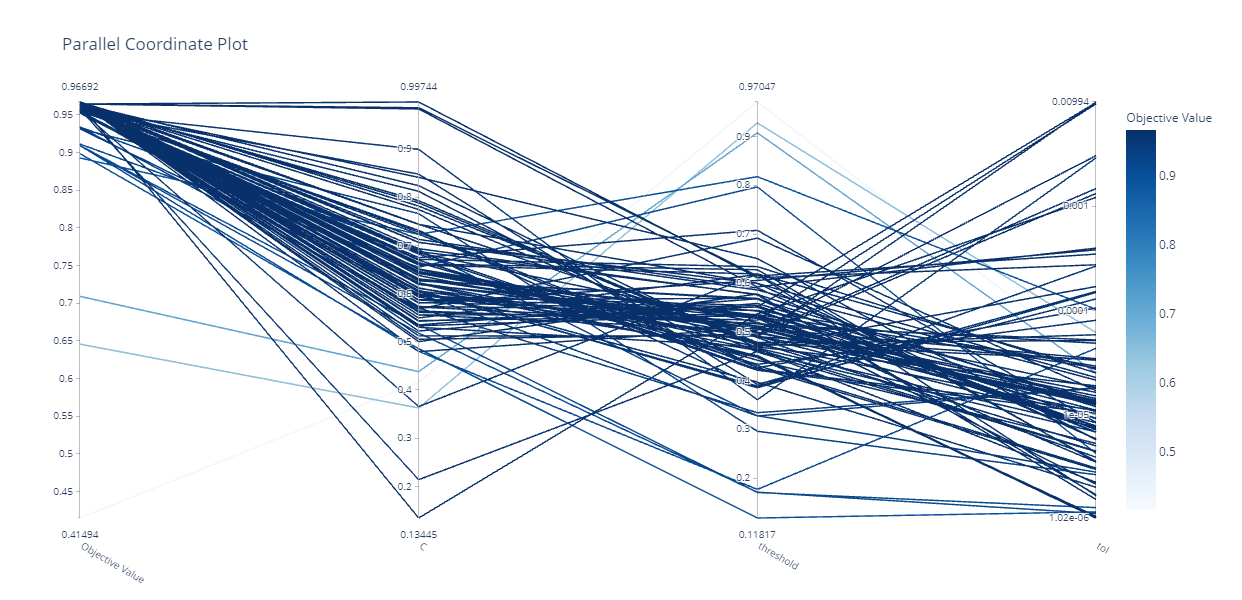

In [17]:
show_study_summary(log_reg_study)

### Random Forest

In [18]:
def forest_objective(trial):
    """
    Objective function for optimizing random forest hyperparameters.

    Parameters
    ----------
    trial : optuna.Trial
        A single optimization trial.

    Returns
    -------
    float
        F1 score obtained using the specified hyperparameters.
    """
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 20, 150),
        "max_depth": trial.suggest_int('max_depth', 10, 30),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None, 2]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    }

    random_forest = RandomForestClassifier(**params)

    random_forest.fit(X_train_val, y_train_val)

    yhat = random_forest.predict(X_test_val)

    f1_score_ = f1_score(y_test_val, yhat)

    return f1_score_

forest_study = optuna.create_study(direction="maximize", study_name="forest_tuning")

forest_study.optimize(forest_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-11-20 07:09:08,617] A new study created in memory with name: forest_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-11-20 07:09:09,353] Trial 2 finished with value: 0.9894736842105263 and parameters: {'n_estimators': 44, 'max_depth': 21, 'max_features': 'sqrt', 'criterion': 'log_loss'}. Best is trial 2 with value: 0.9894736842105263.
[I 2023-11-20 07:09:09,355] Trial 3 finished with value: 0.9921259842519685 and parameters: {'n_estimators': 43, 'max_depth': 19, 'max_features': 2, 'criterion': 'gini'}. Best is trial 3 with value: 0.9921259842519685.
[I 2023-11-20 07:09:09,763] Trial 1 finished with value: 0.992084432717678 and parameters: {'n_estimators': 66, 'max_depth': 29, 'max_features': 'sqrt', 'criterion': 'log_loss'}. Best is trial 3 with value: 0.9921259842519685.
[I 2023-11-20 07:09:10,440] Trial 5 finished with value: 0.9947368421052631 and parameters: {'n_estimators': 75, 'max_depth': 29, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 5 with value: 0.9947368421052631.
[I 2023-11-20 07:09:10,489] Trial 6 finished with value: 0.9842105263157894 and parameters: {'n_est

Best Hyperparameters
{'criterion': 'entropy',
 'max_depth': 29,
 'max_features': 'sqrt',
 'n_estimators': 75}

Accuracy for the Best Hyperparameters
0.9947368421052631


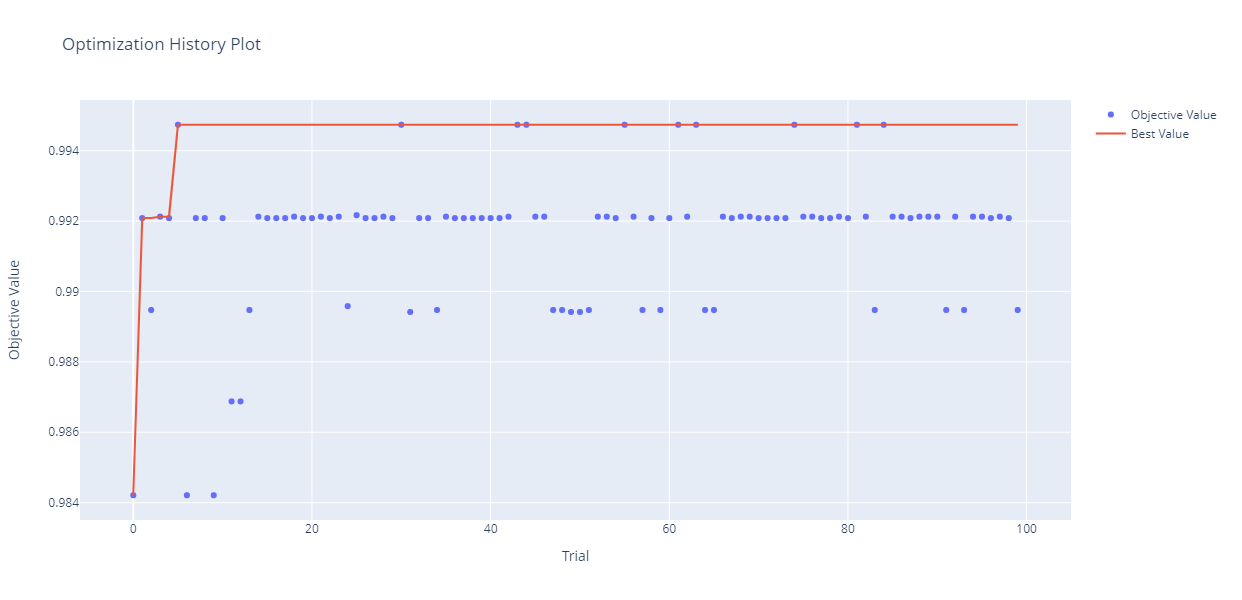

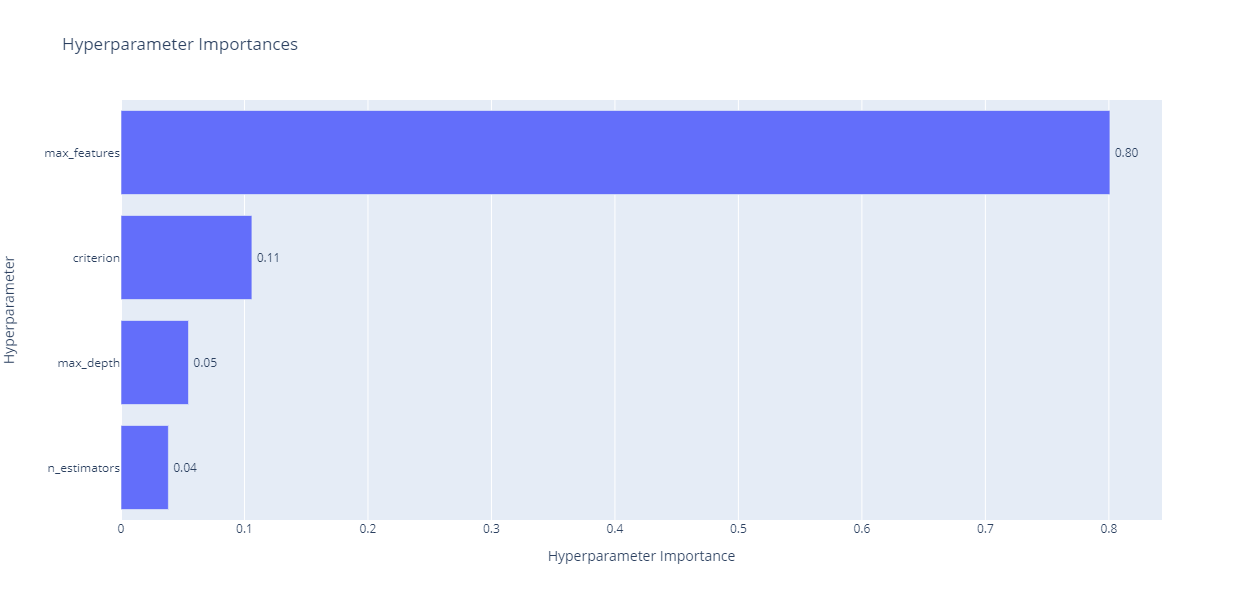

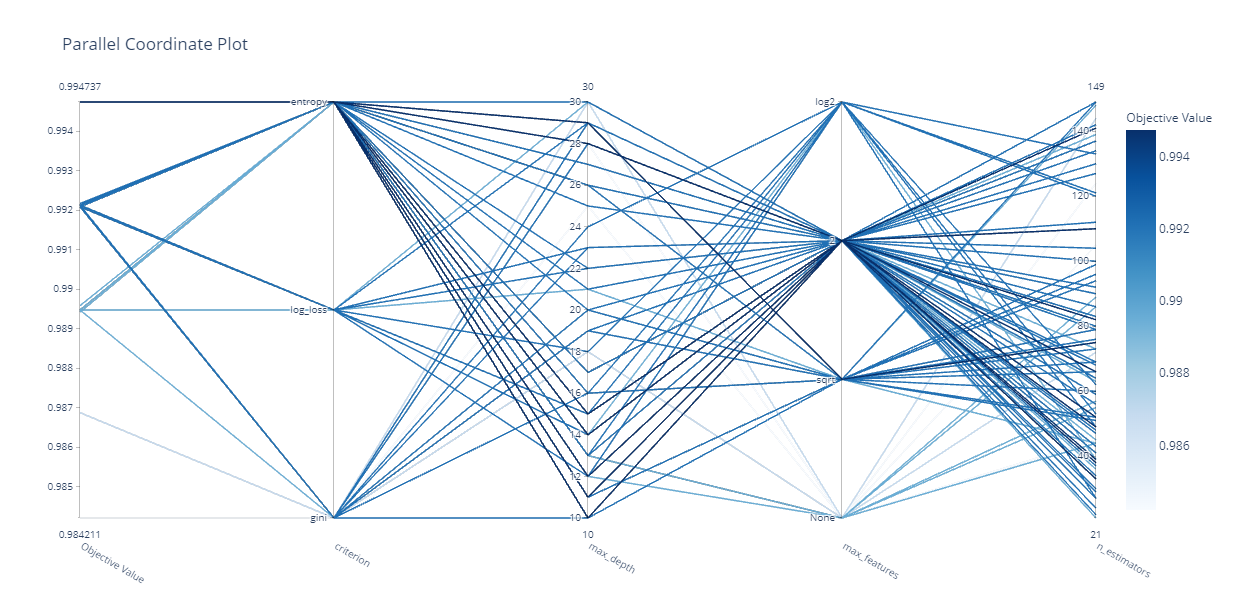

In [19]:
show_study_summary(forest_study)

### Support Vector Machine


In [20]:
def SVC_objective(trial):
    """
    Objective function for optimizing Support Vector Machine (SVM) hyperparameters.

    Parameters
    ----------
    trial : optuna.Trial
        A single optimization trial.

    Returns
    -------
    float
        F1 score obtained using the specified hyperparameters.
    """
    params = {
        "C": trial.suggest_float("C", 0.1, 1, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    }

    SVC_MODEL = SVC(**params)

    SVC_MODEL.fit(X_train_val, y_train_val)

    yhat = SVC_MODEL.predict(X_test_val)

    f1_score_ = f1_score(y_test_val, yhat)

    return f1_score_

SVM_SVC_study = optuna.create_study(direction="maximize", study_name="SVM_tuning")

SVM_SVC_study.optimize(SVC_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-11-20 07:09:38,855] A new study created in memory with name: SVM_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-11-20 07:09:38,939] Trial 2 finished with value: 0.9895833333333333 and parameters: {'C': 0.47261852738076904, 'kernel': 'poly'}. Best is trial 2 with value: 0.9895833333333333.
[I 2023-11-20 07:09:38,940] Trial 3 finished with value: 0.9669211195928753 and parameters: {'C': 0.7885804813133925, 'kernel': 'linear'}. Best is trial 2 with value: 0.9895833333333333.
[I 2023-11-20 07:09:38,962] Trial 1 finished with value: 0.9476309226932668 and parameters: {'C': 0.16353694541907254, 'kernel': 'linear'}. Best is trial 2 with value: 0.9895833333333333.
[I 2023-11-20 07:09:39,009] Trial 5 finished with value: 0.9476309226932668 and parameters: {'C': 0.11694227343763482, 'kernel': 'linear'}. Best is trial 2 with value: 0.9895833333333333.
[I 2023-11-20 07:09:39,023] Trial 4 finished with value: 0.9819121447028424 and parameters: {'C': 0.26839822881006986, 'kernel': 'rbf'}. Best is trial 2 with value: 0.9895833333333333.
[I 2023-11-20 07:09:39,054] Trial 0 finished with value: 0.5520833

Best Hyperparameters
{'C': 0.282103709316639, 'kernel': 'poly'}

Accuracy for the Best Hyperparameters
0.9921671018276762


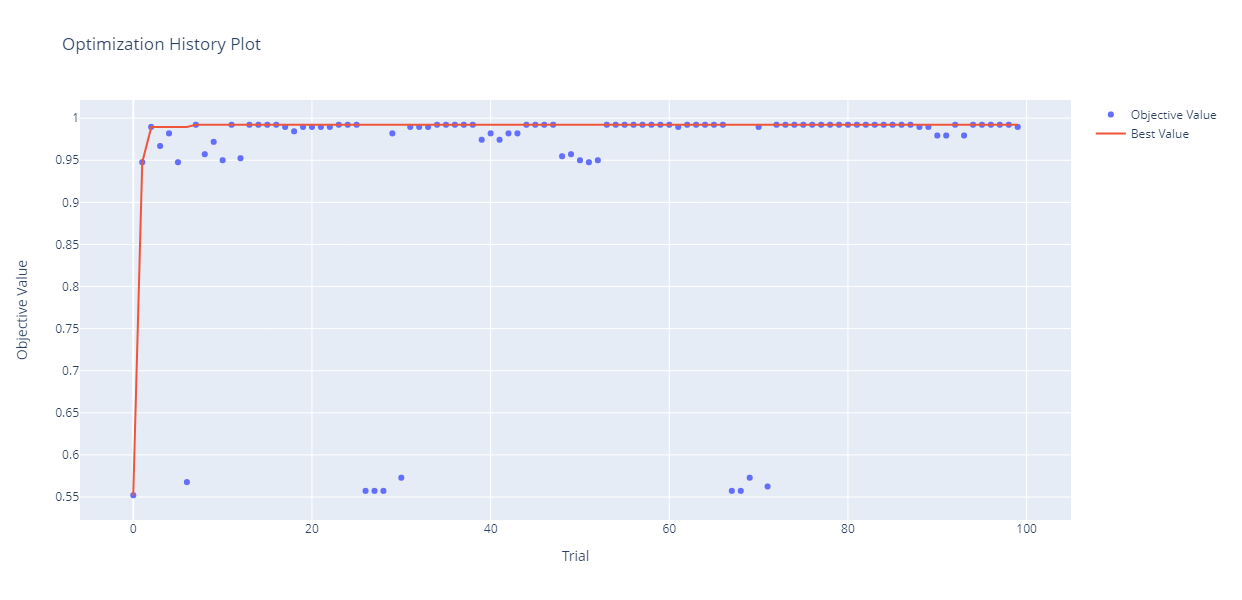

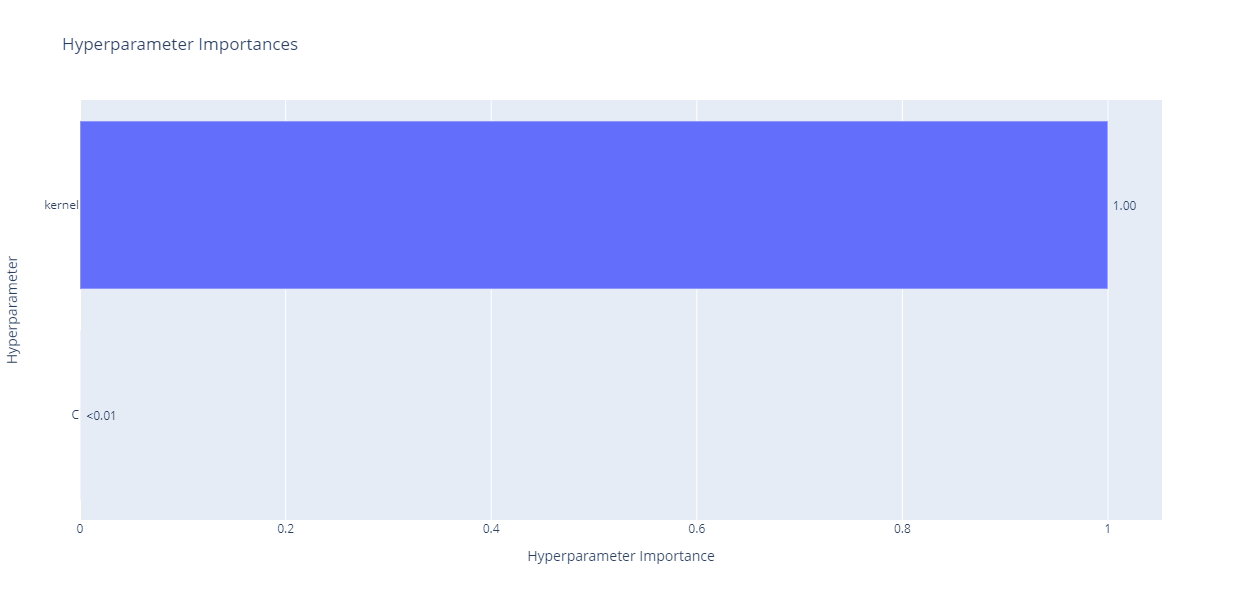

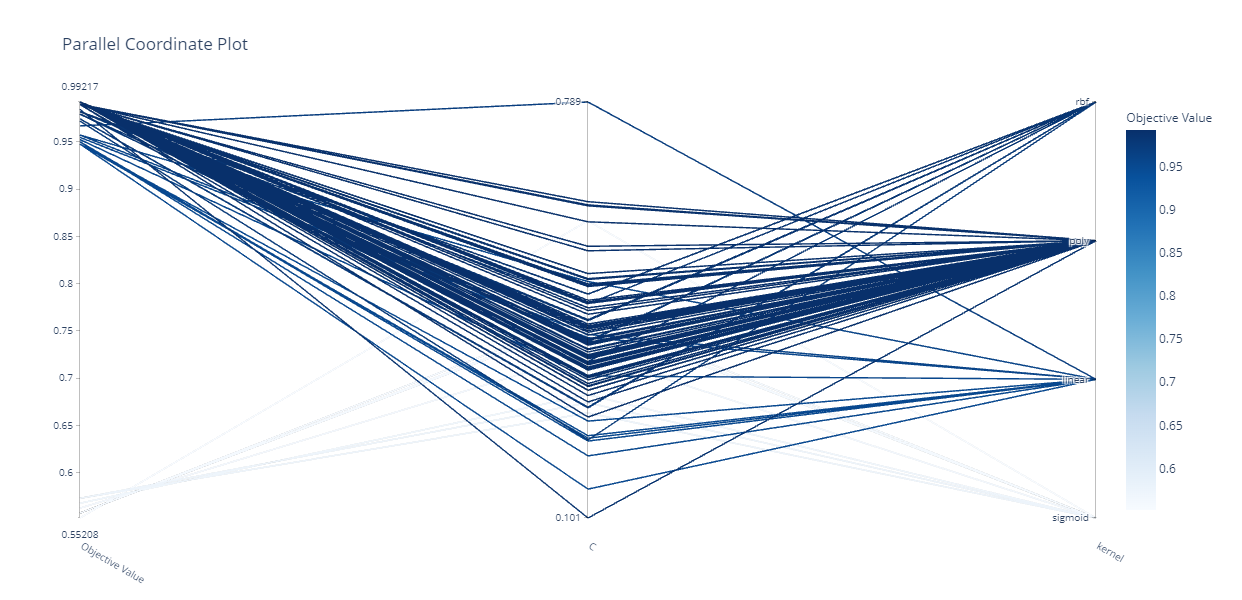

In [21]:
show_study_summary(SVM_SVC_study)

### XGBoost

In [22]:
def XGB_objective(trial):
    """
    Objective function for optimizing XGBoost hyperparameters.

    Parameters
    ----------
    trial : optuna.Trial
        A single optimization trial.

    Returns
    -------
    float
        F1 score obtained using the specified hyperparameters.
    """
    params = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True)
    }

    XGB_model = xgb.XGBClassifier(**params)

    XGB_model.fit(X_train_val, y_train_val)

    yhat = XGB_model.predict(X_test_val)

    f1_score_ = f1_score(y_test_val, yhat)

    return f1_score_

XGB_study = optuna.create_study(direction="maximize", study_name="XGB_tuning")

XGB_study.optimize(XGB_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-11-20 07:09:42,694] A new study created in memory with name: XGB_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-11-20 07:09:43,846] Trial 2 finished with value: 0.9867374005305041 and parameters: {'reg_alpha': 0.6044335929378823, 'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.0002966582327218512}. Best is trial 2 with value: 0.9867374005305041.
[I 2023-11-20 07:09:44,063] Trial 1 finished with value: 0.9894179894179894 and parameters: {'reg_alpha': 0.39877535144874476, 'n_estimators': 350, 'max_depth': 13, 'learning_rate': 0.0011861947855473641}. Best is trial 1 with value: 0.9894179894179894.
[I 2023-11-20 07:09:44,101] Trial 0 finished with value: 0.992084432717678 and parameters: {'reg_alpha': 0.4336551822116993, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.03751678761161311}. Best is trial 0 with value: 0.992084432717678.
[I 2023-11-20 07:09:44,257] Trial 3 finished with value: 0.9867374005305041 and parameters: {'reg_alpha': 0.7669254556898973, 'n_estimators': 450, 'max_depth': 9, 'learning_rate': 0.00038332722442394296}. Best is trial 0 with value: 0.9920844327

Best Hyperparameters
{'learning_rate': 0.05640823972170757,
 'max_depth': 13,
 'n_estimators': 450,
 'reg_alpha': 0.36367791646293485}

Accuracy for the Best Hyperparameters
0.9947368421052631


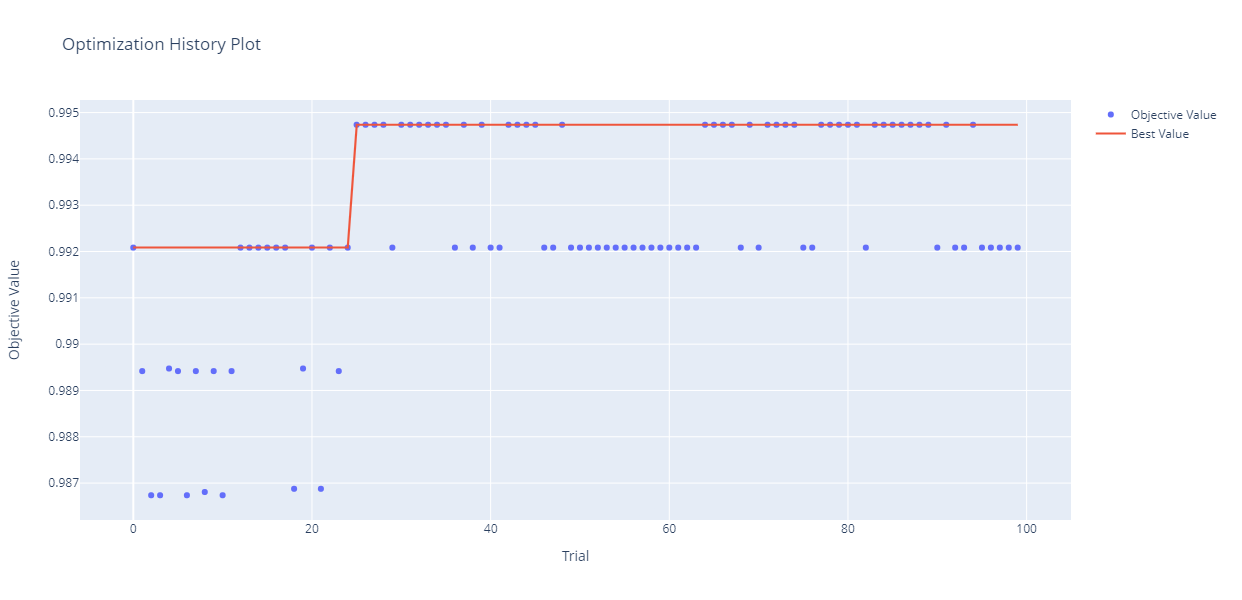

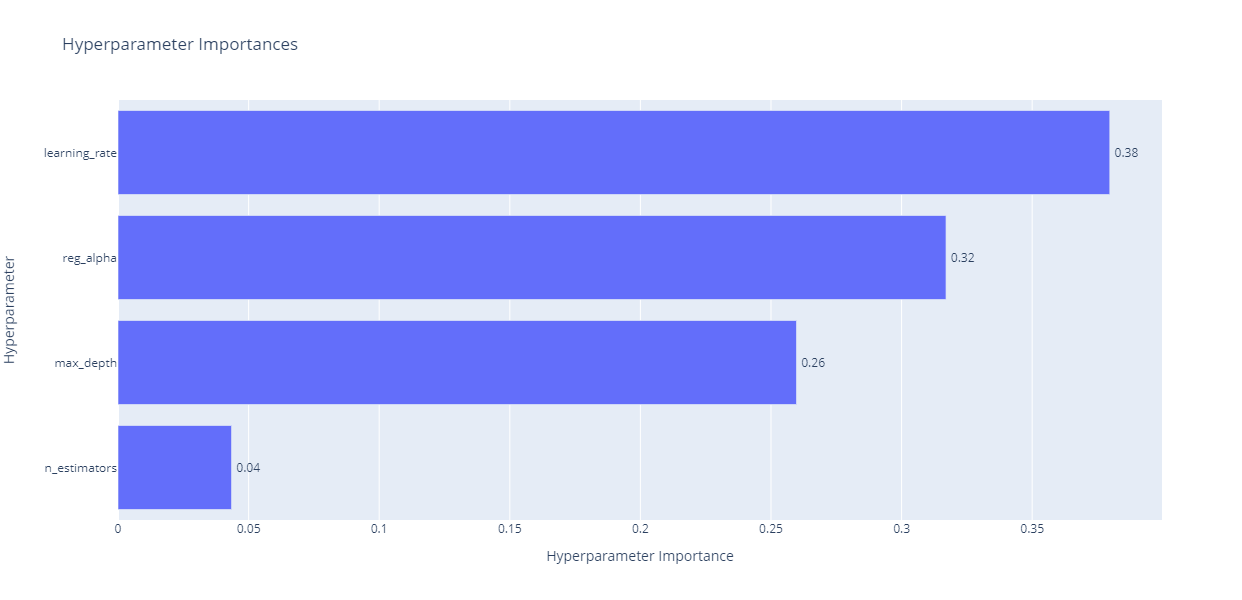

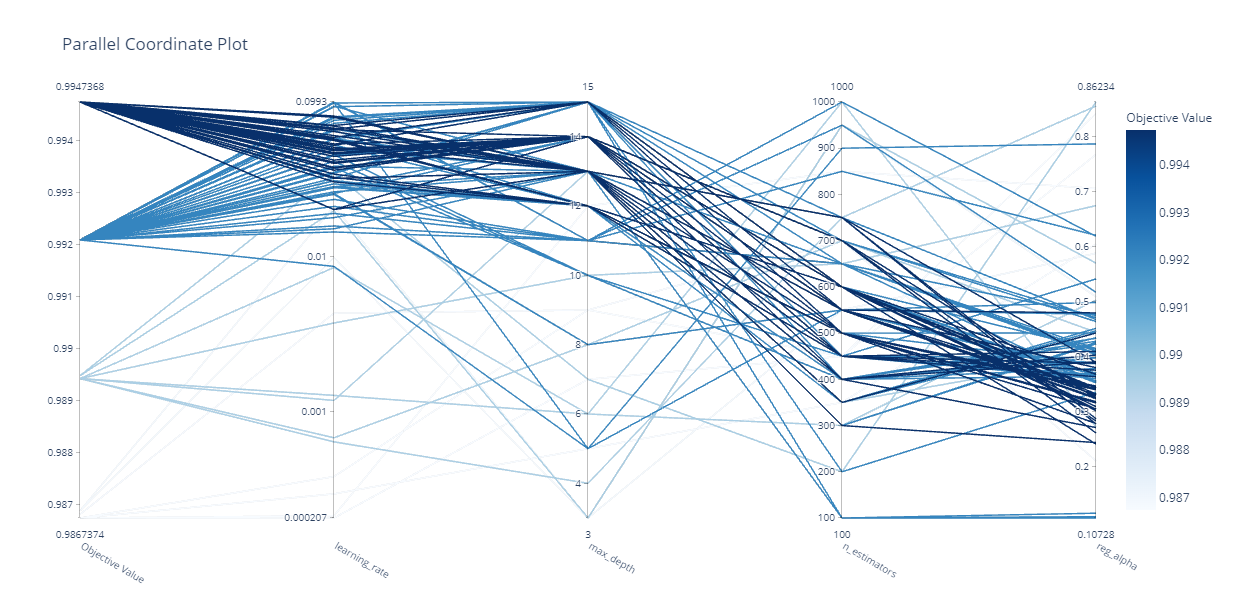

In [23]:
show_study_summary(XGB_study)

### Light GBM

In [24]:
def lightgmb_objective(trial):
    """
    Objective function for optimizing LightGBM hyperparameters.

    Parameters
    ----------
    trial : optuna.Trial
        A single optimization trial.

    Returns
    -------
    float
        F1 score obtained using the specified hyperparameters.
    """
    params = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200, step=10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_categorical("max_depth", [-1, 3, 4, 5]),
        'learning_rate': trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9)
    }
    
    lgbm_model = lgb.LGBMClassifier(**params)
    
    lgbm_model.fit(X_train_val, y_train_val) 
    
    yhat = lgbm_model.predict(X_test_val)
    
    f1_score_ = f1_score(y_test_val, yhat)
    
    return f1_score_

lgbm_study = optuna.create_study(direction="maximize", study_name="lgbm_tuning")

lgbm_study.optimize(lightgmb_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-11-20 07:10:26,538] A new study created in memory with name: lgbm_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-11-20 07:10:26,934] Trial 2 finished with value: 0.9894736842105263 and parameters: {'boosting_type': 'goss', 'num_leaves': 110, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.060295922241580854, 'reg_alpha': 0.855839931474411}. Best is trial 2 with value: 0.9894736842105263.
[I 2023-11-20 07:10:27,197] Trial 0 finished with value: 0.9868073878627968 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.006813943346819454, 'reg_alpha': 0.30793912972583126}. Best is trial 2 with value: 0.9894736842105263.
[I 2023-11-20 07:10:27,424] Trial 1 finished with value: 0.9841269841269842 and parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.00031993845516041616, 'reg_alpha': 0.6661249534180588}. Best is trial 2 with value: 0.9894736842105263.
[I 2023-11-20 07:10:27,451] Trial 5 finished with value: 0.9841269841269842 and parameters: {'boosting_type': 'go

Best Hyperparameters
{'boosting_type': 'goss',
 'learning_rate': 0.03402779294487841,
 'max_depth': 5,
 'n_estimators': 450,
 'num_leaves': 80,
 'reg_alpha': 0.8728605496467743}

Accuracy for the Best Hyperparameters
0.992084432717678


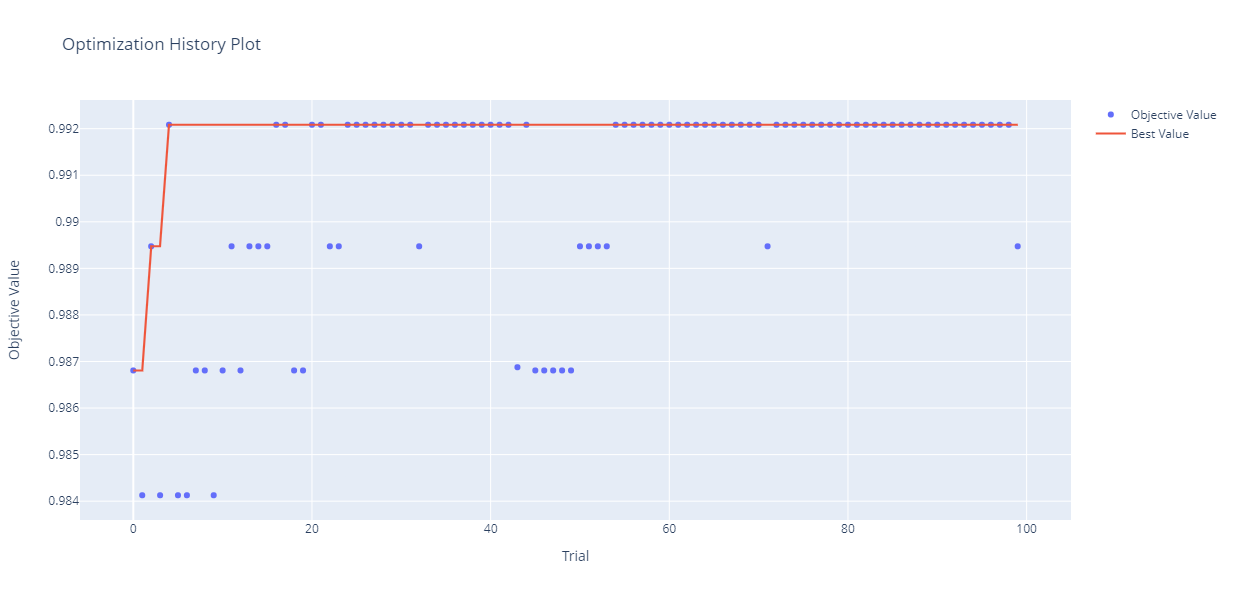

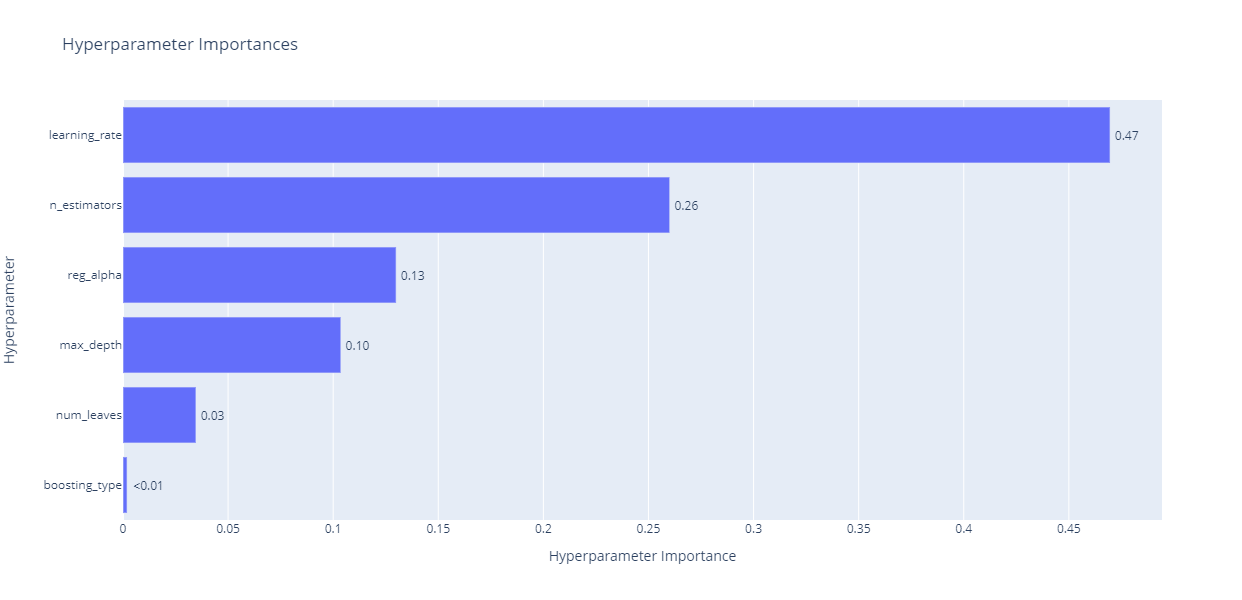

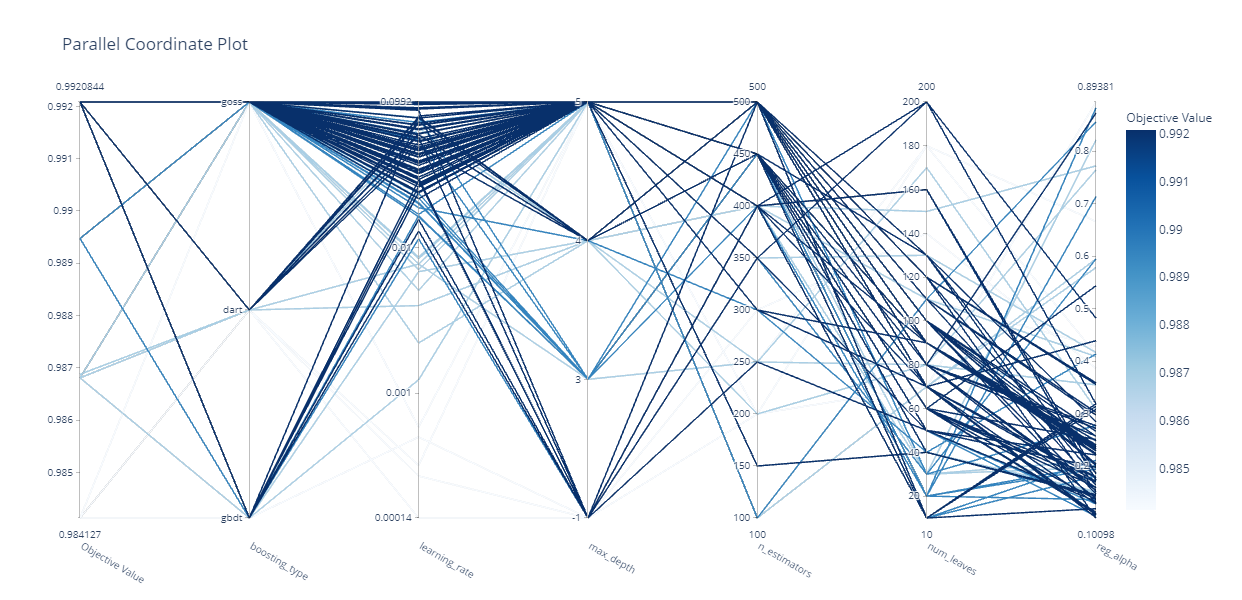

In [25]:
show_study_summary(lgbm_study)

### ANN: Multi-layer Perceptron

#### Load the data using Pytorch

In [26]:
class UTIDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Custom PyTorch dataset for the UTI dataset.

        Parameters
        ----------
        df : pandas.DataFrame
            The dataset as a DataFrame.
        transform : callable, optional
            A function to apply transformations on input features and labels, default is None.

        """
        self.df = df
        self.transform = transform

    def __len__(self):
        """
        Get the length of the dataset.

        Returns
        -------
        int
            The number of samples in the dataset.

        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Get a specific sample from the dataset.

        Parameters
        ----------
        idx : int
            Index of the sample to retrieve.

        Returns
        -------
        tuple
            A tuple containing the input features and labels.

        """
        # Extract features and labels from the DataFrame
        x = self.df.iloc[idx, :-1].values.astype("float32").reshape((self.df.columns.__len__() - 1, 1))
        y = self.df.iloc[idx, -1:].values.astype("long").reshape((1, 1))

        # Apply transformations if provided
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)

        return x, y

#### Transformation

In [27]:
# Define a transformation using torchvision's ToTensor()
transform = transforms.ToTensor()

# Reset indices of the training set
X_train_scaled_reset = X_train_scaled.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)

# Concatenate scaled features and labels into a single DataFrame
df = pd.concat([X_train_scaled_reset, y_train_reset], axis=1)

# Create an instance of the UTIDataset with the training dataset and the specified transform
data = UTIDataset(df, transform)

#### Split the data

In [28]:
train_val_split_ratio = [0.8, 0, 0.2]
train_set_torch, _, val_set_torch = random_split(data, train_val_split_ratio)

In [29]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define batch size
batch_size = 16

# Calculate the size of the training dataset
data_size = len(X_train_scaled_reset)

# Define indices for training and validation sets based on the split ratio
train_indices = list(range(int(data_size - (data_size * train_val_split_ratio[2]))))
val_indices = list(range(int(data_size - (data_size * train_val_split_ratio[0]))))

# Create SubsetRandomSampler instances for training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create DataLoader instances for training and validation sets
train_loader = DataLoader(train_set_torch, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(val_set_torch, batch_size=batch_size, sampler=val_sampler)

#### MLP Architecture

![Alt text](figures/MLP_ARCHITECTURE.jpg)

In [30]:
class ClassifierNN(nn.Module):
    """
    Neural network classifier.

    Parameters
    ----------
    activation_function : torch.nn.Module
        The activation function to be used in the network.

    Attributes
    ----------
    activation_function : torch.nn.Module
        The activation function for the network.
    fcn1 : torch.nn.Linear
        The first fully connected layer with input size 14 and output size 32.
    fcn2 : torch.nn.Linear
        The second fully connected layer with input size 32 and output size 64.
    fcn3 : torch.nn.Linear
        The third fully connected layer with input size 64 and output size 128.
    fcn4 : torch.nn.Linear
        The fourth fully connected layer with input size 128 and output size 2.

    Methods
    -------
    forward(x)
        Forward pass of the neural network.

    """

    def __init__(self, activation_function):
        super().__init__()

        self.activation_function = activation_function

        # Define fully connected layers
        self.fcn1 = nn.Linear(14, 32)
        self.fcn2 = nn.Linear(32, 64)
        self.fcn3 = nn.Linear(64, 128)
        self.fcn4 = nn.Linear(128, 2)

    def forward(self, x):
        """
        Forward pass of the neural network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor with shape (-1, 14).

        Returns
        -------
        torch.Tensor
            Output tensor after the forward pass.
        """
        x = x.view(-1, 14)

        x = self.activation_function(self.fcn1(x))
        x = self.activation_function(self.fcn2(x))
        x = self.activation_function(self.fcn3(x))

        x = self.fcn4(x)

        return x

In [31]:
# Check if CUDA (GPU) is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print the selected device
print(device)

cuda


#### MLP TUNING

In [32]:
def tune_NN(trial, train_loader_, val_loader_):
    """
      Tune a Convolutional Neural Network (CNN) using various hyperparameters.

      Parameters
      ----------
      trial : optuna.Trial
          An Optuna trial object used for hyperparameter optimization.

      train_loader_ : torch.utils.data.DataLoader
          DataLoader for the training dataset.

      val_loader_ : torch.utils.data.DataLoader
          DataLoader for the validation dataset.

      Returns
      -------
      float
          The accuracy of the tuned CNN model on the validation dataset.

      Notes
      -----
      This function performs hyperparameter optimization for a CNN model using the Optuna library.

      The hyperparameters that can be optimized are:
      - Kernel size for convolutional layers
      - Choice of optimizer (SGD, Adam, or RMSprop)
      - Activation functions (ReLU, Leaky ReLU, or Tanh)
      - Learning rate
      - Number of training epochs

      The CNN model is trained and tuned using the specified hyperparameters, and its accuracy on the
      validation dataset is returned.

      Examples
      --------
      >>> import optuna
      >>> study = optuna.create_study(direction='maximize')
      >>> study.optimize(tune_CNN, n_trials=10, args=(train_loader, val_loader))
      >>> best_trial = study.best_trial
      >>> best_accuracy = best_trial.value
      >>> best_params = best_trial.params
      >>> print(f"Best accuracy: {best_accuracy}")
      >>> print(f"Best hyperparameters: {best_params}")
    """
    global device

    optimizers_ = trial.suggest_categorical("optimizer", ["SGD", "Adam", "RMSprop"])
    activation_functions = trial.suggest_categorical("activation function", [F.relu, F.leaky_relu, F.tanh])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    epochs = trial.suggest_int("epochs", 10, 50)

    NN_model = ClassifierNN(activation_functions)

    NN_model = NN_model.to(device)

    criterion = nn.CrossEntropyLoss()

    if optimizers_ == "SGD":
        optimizer = optim.SGD(NN_model.parameters(), lr=learning_rate)
    elif optimizers_ == "Adam":
        optimizer = optim.Adam(NN_model.parameters(), lr=learning_rate)
    elif optimizers_ == "RMSprop":
        optimizer = optim.RMSprop(NN_model.parameters(), lr=learning_rate)

    for _ in range(epochs):
        running_loss = 0.0

        for x_train, y_train in train_loader_:
            x_train = x_train.to(device)
            y_train = y_train.to(device)

            optimizer.zero_grad()
            outputs = NN_model(x_train)
            
            y_train = y_train.flatten()

            loss = criterion(outputs, y_train)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for val_X, val_y in val_loader_:
            val_X = val_X.to(device)
            val_y = val_y.to(device)

            outputs = NN_model(val_X)

            _, predicted = torch.max(outputs.data, 1)

            true_labels.extend([arr.flatten()[0] for arr in val_y.cpu().numpy()])
            predicted_labels.extend(predicted.cpu().numpy())

    f1 = f1_score(true_labels, predicted_labels)

    torch.cuda.empty_cache()

    return f1

In [33]:
# Create an Optuna study for hyperparameter optimization
mlp_study = optuna.create_study(direction="maximize")

# Define the parameters for the optimization study
params = {"train_loader_": train_loader,
          "val_loader_": val_loader}

# Optimize the objective function using Optuna
mlp_study.optimize(lambda trial: tune_NN(trial, **params),
                   n_trials=100,
                   n_jobs=-1,  # Parallelize trials using all available CPUs
                   show_progress_bar=True)

[I 2023-11-20 07:11:05,697] A new study created in memory with name: no-name-da4744e6-e135-48bd-ac7e-3791017141b8


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-11-20 07:11:52,435] Trial 0 finished with value: 0.9761904761904763 and parameters: {'optimizer': 'Adam', 'activation function': <function relu at 0x7df57d28d870>, 'learning_rate': 0.0395077921656851, 'epochs': 10}. Best is trial 0 with value: 0.9761904761904763.
[I 2023-11-20 07:12:10,963] Trial 2 finished with value: 0.9579439252336448 and parameters: {'optimizer': 'SGD', 'activation function': <function tanh at 0x7df57d28e290>, 'learning_rate': 0.003659515984070459, 'epochs': 27}. Best is trial 0 with value: 0.9761904761904763.
[I 2023-11-20 07:12:54,938] Trial 1 finished with value: 0.9505882352941176 and parameters: {'optimizer': 'RMSprop', 'activation function': <function tanh at 0x7df57d28e290>, 'learning_rate': 1.0887877020186291e-05, 'epochs': 35}. Best is trial 0 with value: 0.9761904761904763.
[I 2023-11-20 07:12:56,552] Trial 3 finished with value: 0.9505882352941176 and parameters: {'optimizer': 'RMSprop', 'activation function': <function relu at 0x7df57d28d870>, '

Best Hyperparameters
{'activation function': <function tanh at 0x7df57d28e290>,
 'epochs': 25,
 'learning_rate': 0.002088589807489559,
 'optimizer': 'RMSprop'}

Accuracy for the Best Hyperparameters
0.9927360774818402


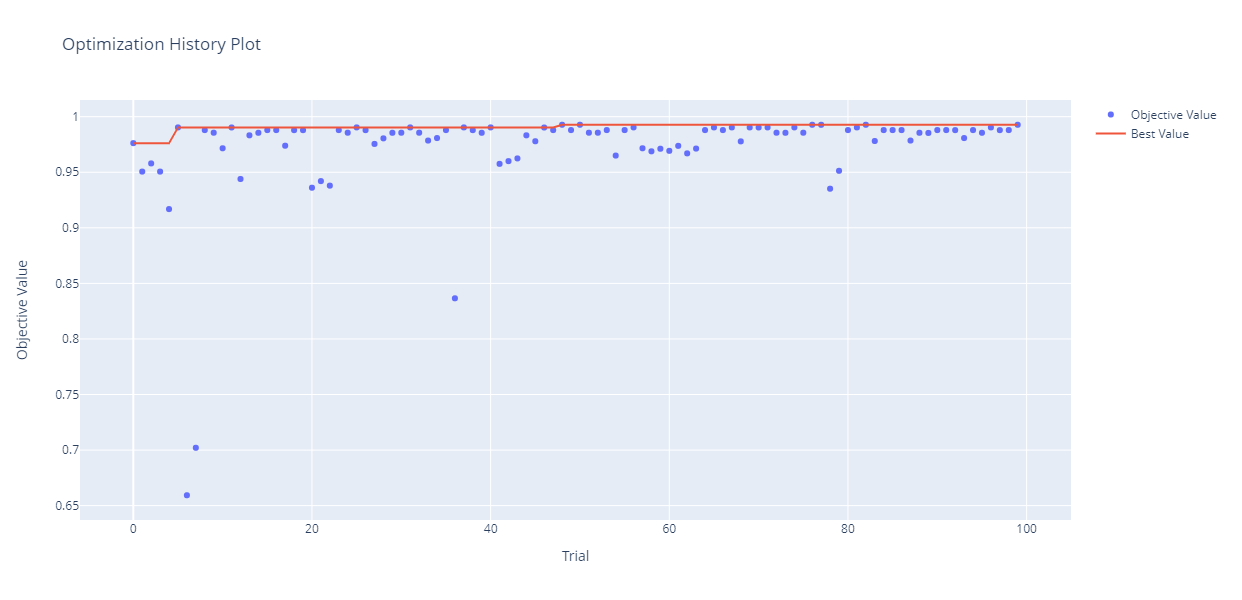

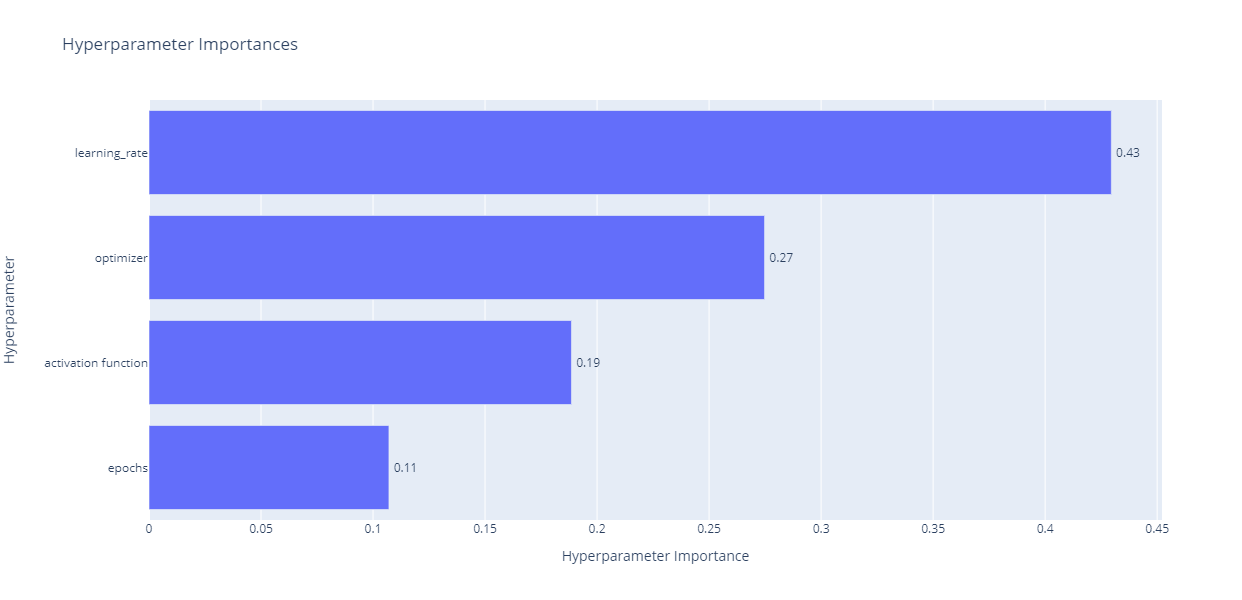

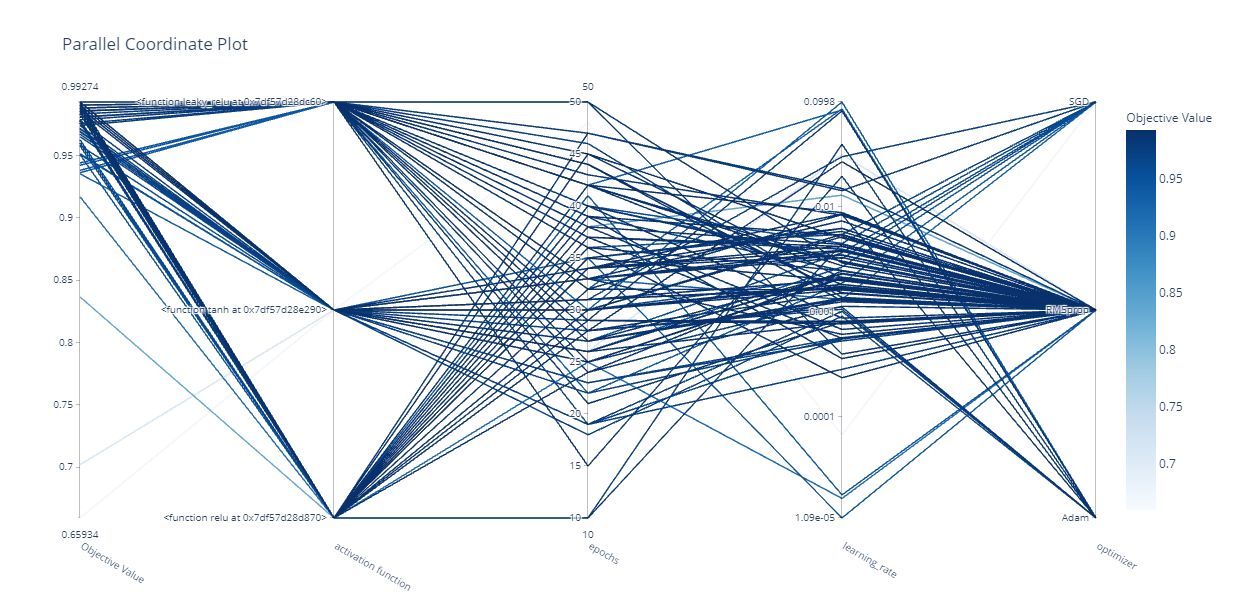

In [34]:
show_study_summary(mlp_study)